In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deepglobe-road-extraction-dataset/class_dict.csv
/kaggle/input/deepglobe-road-extraction-dataset/metadata.csv
/kaggle/input/deepglobe-road-extraction-dataset/valid/704062_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/235424_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/59598_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/156684_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/993402_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/373475_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/791459_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/407466_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/504054_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/832447_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/868508_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/valid/685013_sat.jpg
/kaggle/input/deepglobe-road-extraction-dataset/v

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import flip_left_right, flip_up_down

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import flip_left_right, flip_up_down, adjust_brightness
import matplotlib.pyplot as plt
import os


def sort_by_name(arr, split_at):
    return sorted([f for f in arr if f.split(split_at)[0].isdigit()], key=lambda x: int(x.split(split_at)[0]))


def load_data(dir_path):
    # dir_path = '../satellite-roads/train/'
    directory = os.listdir(dir_path)
    images = []
    masks = []

    for filename in directory:
        if filename.split('.')[1] == 'jpg':
            images.append(filename)
        elif filename.split('.')[1] == 'png':
            masks.append(filename)

    sorted_images = sort_by_name(images, '_')
    sorted_masks = sort_by_name(masks, '_')

    return np.array(sorted_images), np.array(sorted_masks)


def preprocess_data(root_path, sorted_images, sorted_masks, input_size, augmented=False):

    images = []
    masks = []
    for img_file, mask_file in zip(sorted_images, sorted_masks):
        img = load_img(root_path + img_file, target_size=input_size, color_mode='rgb')
        mask = load_img(root_path + mask_file, target_size=input_size, color_mode='grayscale')

        # Convert image and mask to arrays
        img_array = img_to_array(img)
        img_array = img_array / 255.0

        mask_array = img_to_array(mask, dtype=np.bool_)

        # Append images and masks to the lists
        images.append(img_array)
        masks.append(mask_array)

        if augmented:
            images.append(flip_left_right(img_array))
            masks.append(flip_left_right(mask_array))

            images.append(flip_up_down(img_array))
            masks.append(flip_up_down(mask_array))

    # Convert lists to numpy arrays
    images = np.array(images)
    masks = np.array(masks)

    return images, masks


def display_data(dir_path, image_paths, mask_paths):

    fig, axes = plt.subplots(5, 2, figsize=(10, 20))

    # Iterate over the image and mask pairs and display them in subplots
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        # Load the image and mask using your preferred method
        image = plt.imread(dir_path + image_path)
        mask = plt.imread(dir_path + mask_path)

        # Plot the image and mask in the corresponding subplot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask)
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    return

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, Conv2DTranspose

def unet(input_shape, output_layer):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv2 = Dropout(0.1)(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3 = Dropout(0.2)(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4 = Dropout(0.2)(conv4)

    # Bottom
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Dropout(0.3)(conv5)

    # Decoder
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = Concatenate()([conv4, up6])
    conv6 = Dropout(0.2)(merge6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Dropout(0.2)(merge7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)

    up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Dropout(0.1)(merge8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = tf.keras.layers.BatchNormalization()(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = tf.keras.layers.BatchNormalization()(conv8)

    up9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Dropout(0.1)(merge9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = tf.keras.layers.BatchNormalization()(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = tf.keras.layers.BatchNormalization()(conv9)

    # Output
    output = Conv2D(output_layer, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)
    return model

In [6]:
# physical_devices = tf.config.list_physical_devices('GPU')
# print('GPU is available' if len(physical_devices) > 0 else 'Not available')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
# initialize input size and shape
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3) # color images, 3 channels

In [8]:
# Directories for the dataset
train_dir = '/kaggle/input/deepglobe-road-extraction-dataset/train/'

# Load data for train set
train_image_filenames, train_mask_filenames = load_data(train_dir)

print(f'Original train images: {len(train_image_filenames)}')
print(f'Original train masks: {len(train_mask_filenames)}')

Original train images: 6226
Original train masks: 6226


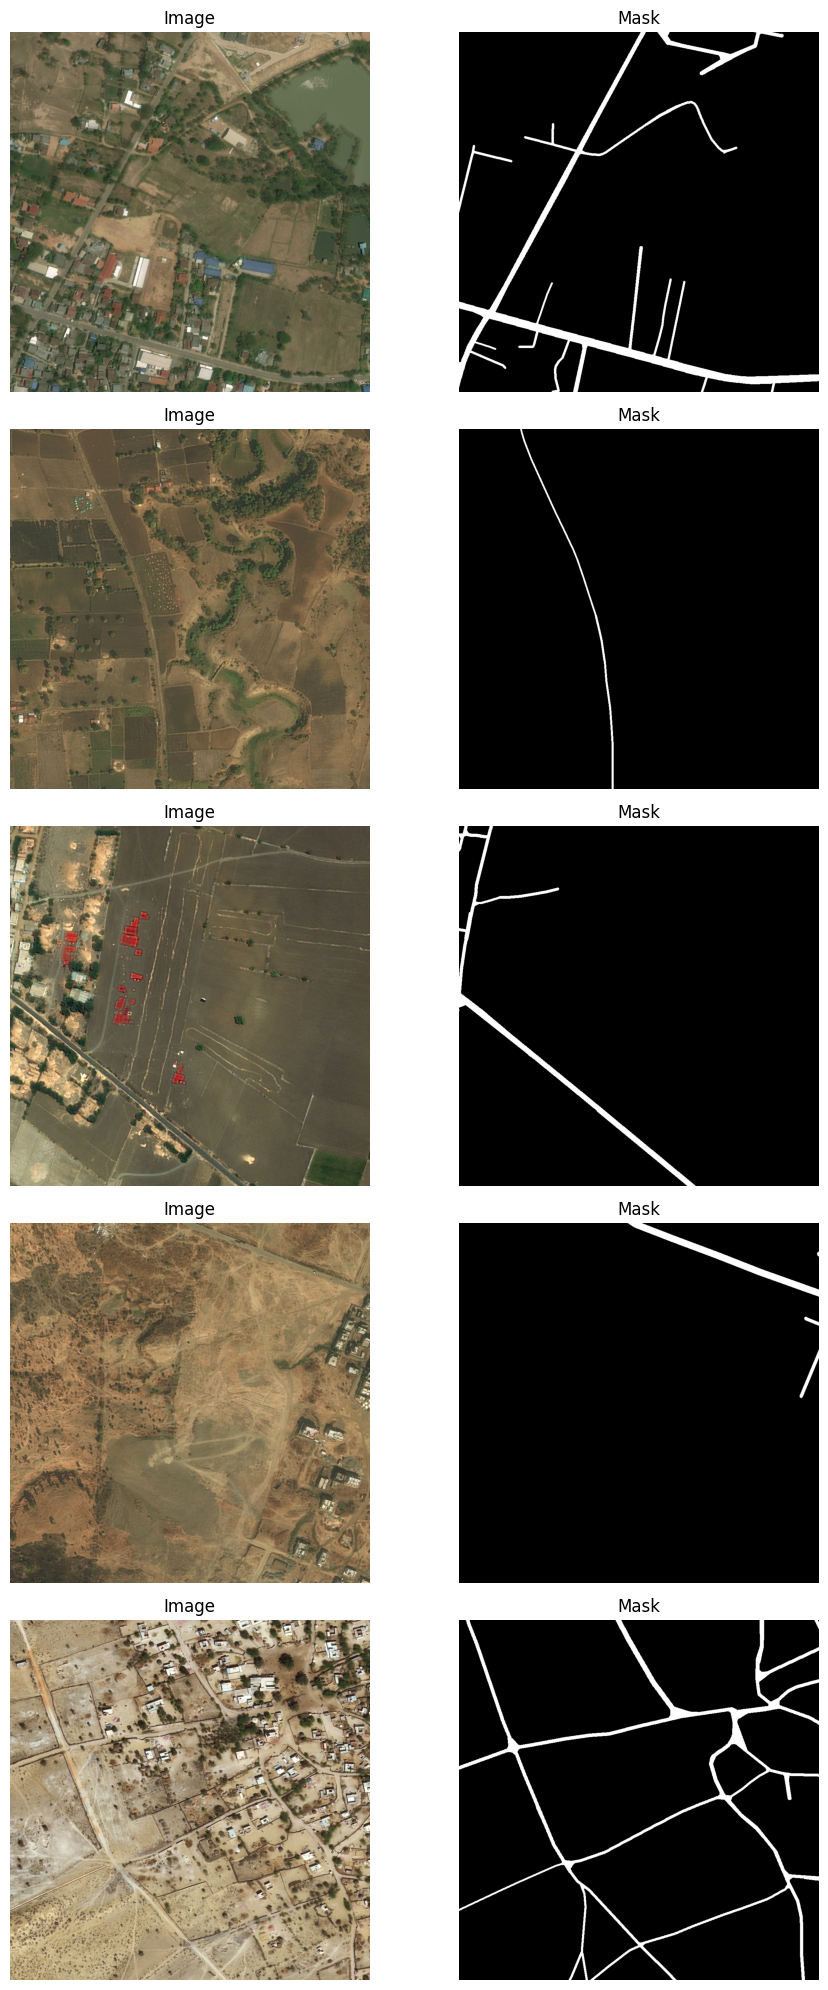

In [9]:
# Display some random samples from the training set
import random

# Convert indices to integers
random_indices = random.sample(range(len(train_image_filenames)), 5)

# Use list comprehension to select images and masks
sampled_image_filenames = [train_image_filenames[i] for i in random_indices]
sampled_mask_filenames = [train_mask_filenames[i] for i in random_indices]

# Display the data
display_data(train_dir, sampled_image_filenames, sampled_mask_filenames)

In [10]:
# Sample 10% of the training data
def sample_data(image_filenames, mask_filenames, percentage):
    data_size = int(len(image_filenames) * percentage)
    selected_indices = np.random.choice(len(image_filenames), data_size, replace=False)
    sampled_images = [image_filenames[i] for i in selected_indices]
    sampled_masks = [mask_filenames[i] for i in selected_indices]
    return sampled_images, sampled_masks

train_image_filenames, train_mask_filenames = sample_data(train_image_filenames, train_mask_filenames, 0.1)

print(f'Sampled 10% train images: {len(train_image_filenames)}')
print(f'Sampled 10% train masks: {len(train_mask_filenames)}')

# Split sampled data into 70% train, 20% validation, 10% test
train_image_filenames, temp_image_filenames, train_mask_filenames, temp_mask_filenames = train_test_split(
    train_image_filenames, train_mask_filenames, test_size=0.3, random_state=42
)
val_image_filenames, test_image_filenames, val_mask_filenames, test_mask_filenames = train_test_split(
    temp_image_filenames, temp_mask_filenames, test_size=1/3, random_state=42
)

print(f'Split data:')
print(f' - Train images: {len(train_image_filenames)}')
print(f' - Validation images: {len(val_image_filenames)}')
print(f' - Test images: {len(test_image_filenames)}')

Sampled 10% train images: 622
Sampled 10% train masks: 622
Split data:
 - Train images: 435
 - Validation images: 124
 - Test images: 63


In [11]:
# Preprocess data
print('Preprocessing data...')
with tf.device("/device:GPU:0"):
    train_images, train_masks = preprocess_data(train_dir, train_image_filenames, train_mask_filenames, input_size=INPUT_SIZE, augmented=False)
    val_images, val_masks = preprocess_data(train_dir, val_image_filenames, val_mask_filenames, input_size=INPUT_SIZE, augmented=False)
    test_images, test_masks = preprocess_data(train_dir, test_image_filenames, test_mask_filenames, input_size=INPUT_SIZE, augmented=False)

print(f'Preprocessed data shapes:')
print(f' - Train images: {train_images.shape}, Train masks: {train_masks.shape}')
print(f' - Validation images: {val_images.shape}, Validation masks: {val_masks.shape}')
print(f' - Test images: {test_images.shape}, Test masks: {test_masks.shape}')

Preprocessing data...
Preprocessed data shapes:
 - Train images: (435, 256, 256, 3), Train masks: (435, 256, 256, 1)
 - Validation images: (124, 256, 256, 3), Validation masks: (124, 256, 256, 1)
 - Test images: (63, 256, 256, 3), Test masks: (63, 256, 256, 1)


In [12]:
# save check point
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/save_best.keras', verbose=1, save_best_only=True)

In [13]:
# Initialize the model
model = unet(INPUT_SHAPE, output_layer=1)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 1,946,993 (7.43 MB)

 Trainable params: 1,944,049 (7.42 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [14]:
# Correct optimizer import for Keras 3.x
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
!pip freeze > library_versions.txt 

In [16]:
# Train the model
epochs = 30
print('Training the model...')
with tf.device("/device:GPU:0"):
    history = model.fit(train_images, train_masks, batch_size=16, epochs=epochs, validation_data=(val_images, val_masks), callbacks=[checkpoint])

Training the model...
Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5662 - loss: 0.7794
Epoch 1: val_loss improved from inf to 3.45140, saving model to models/save_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 219s 7s/step - accuracy: 0.5686 - loss: 0.7771 - val_accuracy: 0.8053 - val_loss: 3.4514
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8576 - loss: 0.6024
Epoch 2: val_loss improved from 3.45140 to 1.52361, saving model to models/save_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 199s 7s/step - accuracy: 0.8583 - loss: 0.6018 - val_accuracy: 0.6650 - val_loss: 1.5236
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9173 - loss: 0.5278
Epoch 3: val_loss improved from 1.52361 to 0.63194, saving model to models/save_best.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 197s 7s/step - accuracy: 0.9176 - loss: 0.5272 - val_accuracy: 0.7208 - val_loss: 0.6319
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9463 - loss: 0.4542
Epoch 4: val_loss did not imp

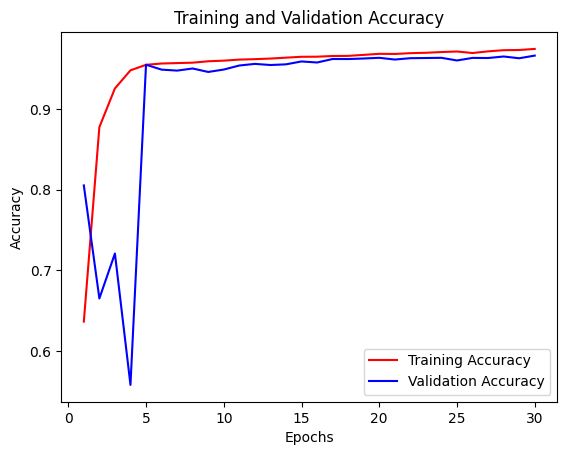

In [17]:
# Plot training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# Save the trained model
print('Saving the trained model...')
model.save('models/roads_extraction01.h5')

Saving the trained model...


In [19]:
# Evaluate on test set
print('Evaluating on test set...')
eval = model.evaluate(test_images, test_masks)
print(f'Test accuracy: {eval[1]:.2f}')

Evaluating on test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.9585 - loss: 0.1171
Test accuracy: 0.96


Loading saved model...
Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


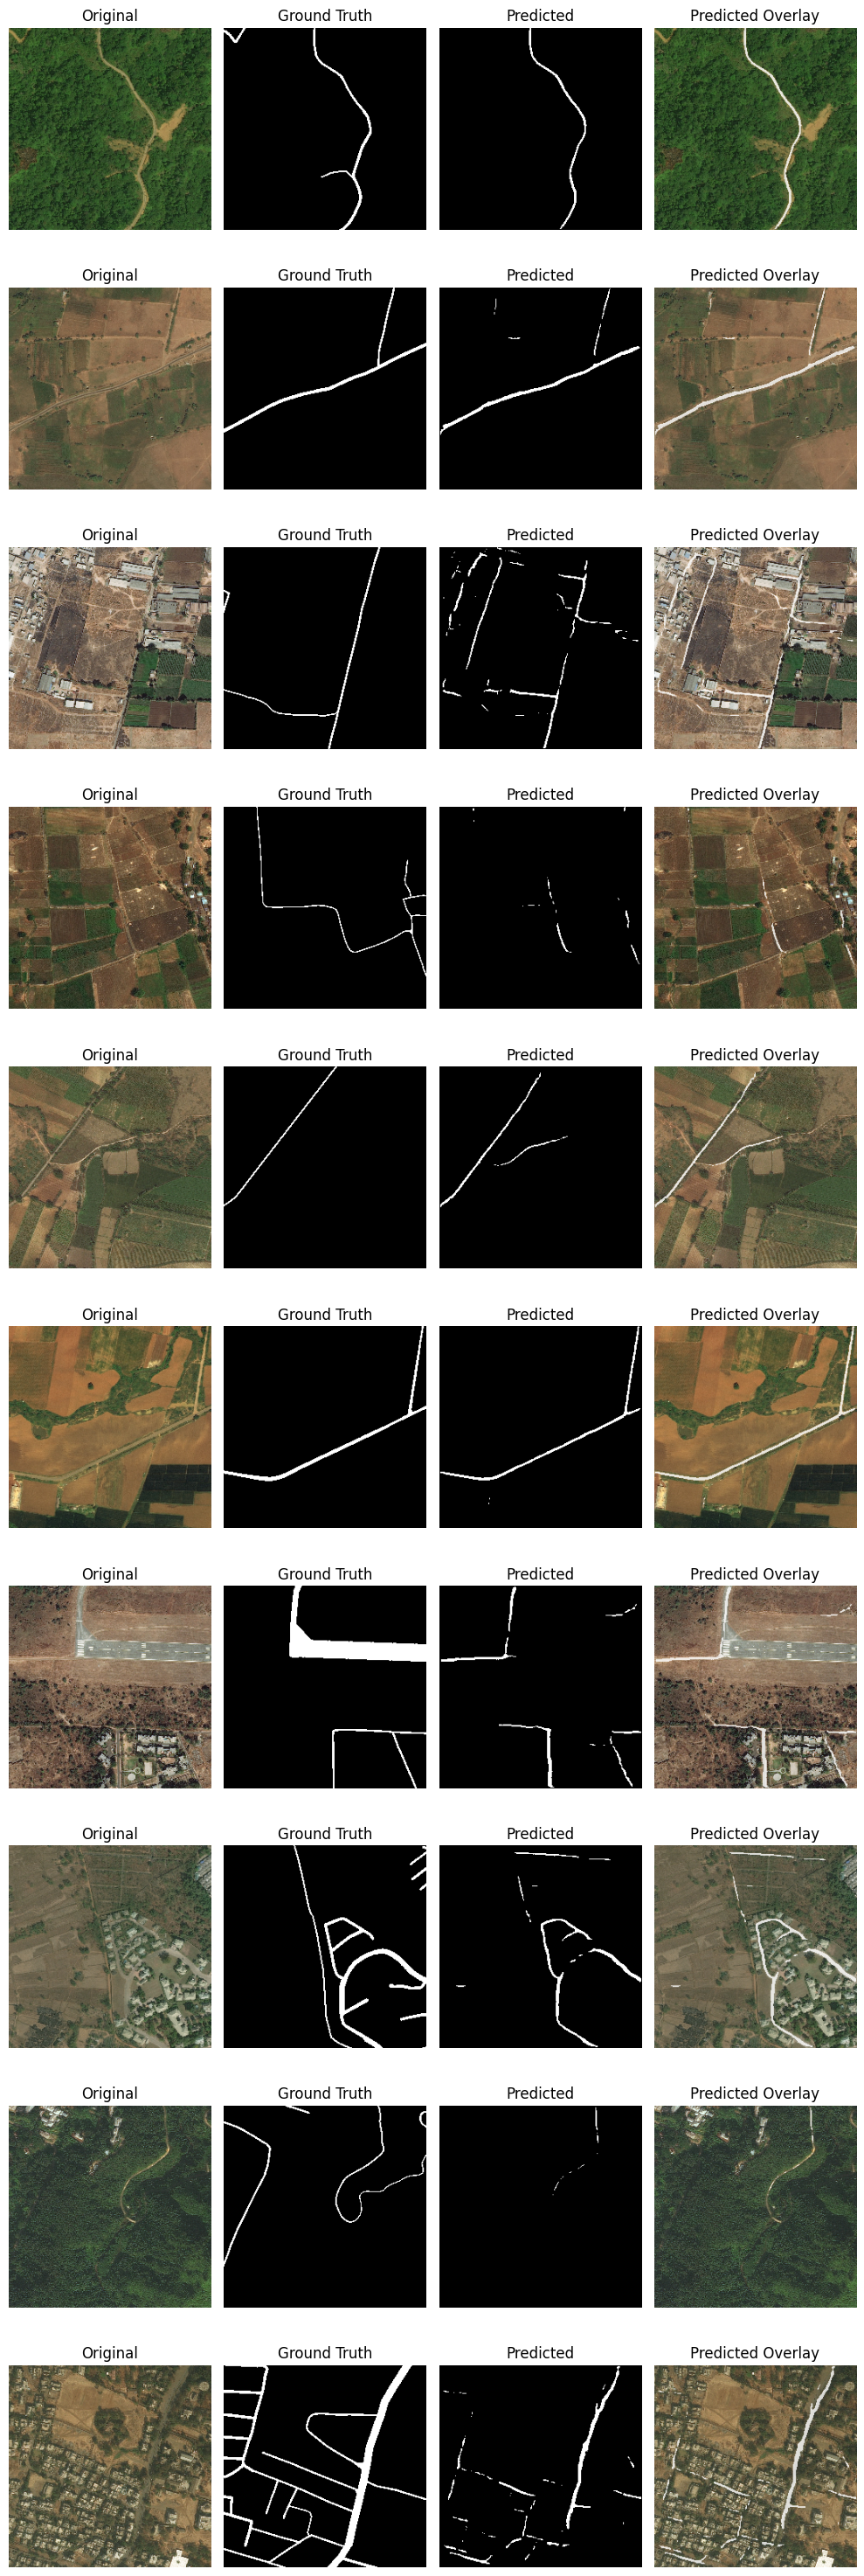

In [20]:
# Load model (if interrupted)
from tensorflow.keras.models import load_model
print('Loading saved model...')
model = load_model('models/roads_extraction01.h5')


# Predict and visualize 10 random predictions from the test set
print('Making predictions...')
random_indices = random.sample(range(0, len(test_images)), 10)
test_sample = test_images[random_indices]

predictions = model.predict(test_sample)
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(10, 4, figsize=(10, 3*10))
for i in range(len(test_sample)):
    image = (test_sample[i] * 255).astype(np.uint8)
    mask = predictions[i]
    ground_truth = test_masks[random_indices][i] * np.array([255, 255, 255])

    overlay = image.copy()
    mask = np.repeat(mask, 3, axis=2) 
    inverted_mask = 1 - mask
    yellow_mask = np.array([255, 255, 255]) * mask
    result = image * inverted_mask + yellow_mask
    alpha = 0.2
    predicted_overlay = cv2.addWeighted(overlay, alpha, result.astype(overlay.dtype), 1 - alpha, 0)

    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(ground_truth)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(yellow_mask)
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(predicted_overlay)
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig('result.png', bbox_inches='tight')
plt.show()

# Thank you